## Dependencias

In [1]:
import numpy as np
import pandas as pd
import os
import json
from sqlalchemy.engine import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scikitplot.metrics import plot_roc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


from scipy import stats
from varclushi import VarClusHi

from functools import reduce

import pickle
import asyncio
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
cf.go_offline()

In [2]:
def freq(df,var):
    if type(var)!=list:
        var = [var]
    for v in var:
        aux = df[v].value_counts().sort_index().to_frame().rename(columns={v:'FA'})
        aux['FR'] = aux['FA']/aux['FA'].sum()
        aux[['FAA','FRA']] = aux.apply(np.cumsum)
        print("Tabla de frecuencias para la variable **",v,"**","\n"*2)
        print(aux,"\n"*2)

In [3]:
dic=pd.read_excel('SIMAEC_NPS_Dic.xlsx')
nov=pd.read_excel('SIMAEC_NPS_Nov.xlsx')
oc= pd.read_excel('SIMAEC_NPS_Oct.xlsx')
sep=pd.read_excel('SIMAEC_NPS_Sep.xlsx')
ago=pd.read_excel('SIMAEC_NPS_Ago.xlsx')
jul=pd.read_excel('SIMAEC_NPS_Jul.xlsx')
jun=pd.read_excel('SIMAEC_NPS_Jun.xlsx')
may=pd.read_excel('SIMAEC_NPS_May.xlsx')
abr=pd.read_excel('SIMAEC_NPS_Abr.xlsx')
mar=pd.read_excel('SIMAEC_NPS_Mar.xlsx')
feb=pd.read_excel('SIMAEC_NPS_Feb.xlsx')
ene=pd.read_excel('SIMAEC_NPS_Ene.xlsx')

In [17]:
df=pd.concat([ene,feb,mar,abr,may,jun,jul,ago,sep,oc,nov,dic])

In [5]:
df.shape

(426630, 11)

In [6]:
a=[]
for file in os.listdir(r'C:\Users\VDMG015\Documents\Esteban\Tramites\Datos'):
        cdmx = pd.read_csv('Datos/'+file, dtype='str', usecols=['StartDate','telefonoUsuario','Q6'])
        cdmx = cdmx.iloc[2:].reset_index(drop=True)
        cdmx['StartDate']=pd.to_datetime(cdmx['StartDate'], format='%Y-%m-%d')
        cdmx['StartDate']=cdmx['StartDate'].dt.date
        cdmx = cdmx.rename(columns={'telefonoUsuario':'linea','StartDate':'fecha','Q6':'Solucion'})
        cdmx['fecha'] = cdmx['fecha'].astype(str)
        cdmx['Solucion'] = cdmx['Solucion'].replace({'Sí, y estoy satisfecho con el resultado.':'Sí', 'Sí, pero no estoy satisfecho con el resultado.':'Sí','No, mi requerimiento/trámite no se resolvió.':'No' })
        print(file)
        a.append(cdmx)
qx=pd.concat(a)

Encuesta CAC F_22 diciembre 2021_12.49.csv
Encuesta CAC F_23 diciembre 2021_17.34.csv
Encuesta CAC F_24 diciembre 2021_12.52.csv
Encuesta CAC F_24 diciembre 2021_13.00.csv


In [7]:
qx.drop_duplicates().shape, qx.shape

((875429, 3), (879918, 3))

In [8]:
qx=qx.drop_duplicates().reset_index(drop=True)

In [18]:
df['region']=df['region'].astype(str)

In [19]:
df['tramites']=df['tramites'].astype(str)

In [20]:
df['linea'] = df['linea'].astype(str)

In [21]:
df=df.merge(qx)

In [22]:
df=df[df['NPS_Asesor'].isin(['Detractor','Promotor'])].reset_index(drop=True)
df=df.dropna().reset_index(drop=True)

In [26]:
df=df.rename(columns={'tiempo_espera':'c_tiempo_espera','tiempo_tramite':'c_tiempo_tramite','motivo':'d_motivo'})

In [27]:
df['target']=(df['NPS_Asesor']=='Detractor').astype(int)

In [23]:
df.head()

,linea,fecha,tiempo_espera,tiempo_tramite,tramites,motivo,cac,region,Asesor,NPS_Asesor,NPS_CAC,Solucion
0,2211011053,2021-01-07,19,352,1,A PORTABILIDAD,PUEBLA V,7,PAC3AD8,Promotor,Promotor,Sí
1,2211020306,2021-01-22,75,816,1,A INFORMES DE PORTABILIDAD,PUEBLA ZOCALO,7,PACD35A,Promotor,Promotor,Sí
2,2211030413,2021-01-26,64,476,1,A POR ACTUALIZACION VERSION,PUE II SAN ANGEL,7,PACF9E1,Promotor,Promotor,Sí
3,2211035205,2021-01-19,46,798,1,A INGRESO Y ENTREGA DE EQUIPO (REVISION / REPA...,SAN PEDRO,7,PACD835,Promotor,Promotor,Sí
4,2211056982,2021-01-19,24,530,1,A INFORMES DE PORTABILIDAD,GALERIAS TLAXCALA,7,PACFADD,Promotor,Promotor,Sí


In [24]:
df=df[df['Solucion']=='Sí'].reset_index(drop=True)

## Variables

In [28]:
um = ['linea','fecha']
varc = [v for v in df.columns if v[:2]=='c_']
vard = [v for v in df.columns if v[:2]=='d_']
vart =['target']
len(varc),len(vard)

(2, 1)

In [29]:
df=df.drop_duplicates(um).reset_index(drop=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301143 entries, 0 to 301142
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   linea             301143 non-null  object
 1   fecha             301143 non-null  object
 2   c_tiempo_espera   301143 non-null  int64 
 3   c_tiempo_tramite  301143 non-null  int64 
 4   tramites          301143 non-null  object
 5   d_motivo          301143 non-null  object
 6   cac               301143 non-null  object
 7   region            301143 non-null  object
 8   Asesor            301143 non-null  object
 9   NPS_Asesor        301143 non-null  object
 10  NPS_CAC           301143 non-null  object
 11  Solucion          301143 non-null  object
 12  target            301143 non-null  int32 
dtypes: int32(1), int64(2), object(10)
memory usage: 28.7+ MB


## Análisis Exploratorio

#### Varianza Nula

In [31]:
vt = VarianceThreshold()
vt.fit(df[varc])

VarianceThreshold()

In [32]:
df[varc]

,c_tiempo_espera,c_tiempo_tramite
0,19,352
1,75,816
2,64,476
3,46,798
4,24,530
...,...,...
301138,30,345
301139,25,1477
301140,303,3311
301141,28,62


In [33]:
vt.transform(df[varc])

array([[  19,  352],
       [  75,  816],
       [  64,  476],
       ...,
       [ 303, 3311],
       [  28,   62],
       [ 469,  755]], dtype=int64)

In [34]:
varc = [v for v,f in zip(varc,vt.get_support()) if f]
len(varc)

2

In [35]:
varc

['c_tiempo_espera', 'c_tiempo_tramite']

In [59]:
labels=['(0 - 30seg]', '(30seg - 1min]', '(1min - 2min]', '(2min - 4min]', '(4min - 8min]', '(8min - 15min]', '+15']

[30, 60, 120, 240, 480]

#### Discretización

In [74]:
df['d_c_tiempo_espera']=pd.cut(df['c_tiempo_espera'],bins=[0]+[(30*2**x) for x in range(5)]+[900, np.inf],right=True, labels=['(0 - 30seg]', '(30seg - 1min]', '(1min - 2min]', '(2min - 4min]', '(4min - 8min]', '(8min - 15min]', '+15']).astype(str)
df['d_c_tiempo_tramite']=pd.cut(df['c_tiempo_tramite'],bins=[x*60 for x in range(0,70,10)] + [np.inf],right=True, labels=['(0 - 10min]', '(10min - 20min]', '(20min - 30min]', '(30min - 40min]', '(40min - 50min]', '(50min - 60min]', '+1hr']).astype(str)

In [125]:
def discretizar(k,metodo,variable):
    nm = df[um+[variable]].copy()

    kb = KBinsDiscretizer(n_bins=k,encode='ordinal',strategy=metodo)
    kb.fit(nm[[variable]])

    nm['d'] = kb.transform(nm[[variable]])
    mapa = dict(zip(range(k),['%02d. |%.1f---%.1f|'%(i+1,*s) for i,s in enumerate(list(zip(kb.bin_edges_[0],kb.bin_edges_[0][1:])))]))
    nm['d'].replace(mapa,inplace=True)
    nombre = f'd_{metodo[0]}_{k}_{variable}'
    nm = nm[um+['d']].rename(columns={'d':nombre})
    
    return nm

In [126]:
l=[]
for i in [(k,m,v) for k in range(2,6) for m in ['quantile','uniform'] for v in varc]:
    a,b,c=i
    l.append(discretizar(a,b,c).iloc[:,2])

In [127]:
dfd=pd.concat(l,axis=1)

In [128]:
dfd[um]=df[um]

In [79]:
varcd = ['d_c_tiempo_tramite','d_c_tiempo_espera']

In [80]:
df

,linea,fecha,c_tiempo_espera,c_tiempo_tramite,tramites,d_motivo,cac,region,Asesor,NPS_Asesor,NPS_CAC,Solucion,target,d_c_tiempo_espera,d_c_tiempo_tramite
0,2211011053,2021-01-07,19,352,1,A PORTABILIDAD,PUEBLA V,7,PAC3AD8,Promotor,Promotor,Sí,0,(0 - 30seg],(0 - 10min]
1,2211020306,2021-01-22,75,816,1,A INFORMES DE PORTABILIDAD,PUEBLA ZOCALO,7,PACD35A,Promotor,Promotor,Sí,0,(1min - 2min],(10min - 20min]
2,2211030413,2021-01-26,64,476,1,A POR ACTUALIZACION VERSION,PUE II SAN ANGEL,7,PACF9E1,Promotor,Promotor,Sí,0,(1min - 2min],(0 - 10min]
3,2211035205,2021-01-19,46,798,1,A INGRESO Y ENTREGA DE EQUIPO (REVISION / REPA...,SAN PEDRO,7,PACD835,Promotor,Promotor,Sí,0,(30seg - 1min],(10min - 20min]
4,2211056982,2021-01-19,24,530,1,A INFORMES DE PORTABILIDAD,GALERIAS TLAXCALA,7,PACFADD,Promotor,Promotor,Sí,0,(0 - 30seg],(0 - 10min]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301138,9999940590,2021-12-16,30,345,1,A INFORMES DE PORTABILIDAD,ITZAES,8,RAC3026,Promotor,Promotor,Sí,0,(0 - 30seg],(0 - 10min]
301139,9999945098,2021-12-11,25,1477,1,A VENTA DE AMIGO KIT,TUXTLA III NORTE,8,RAC88DB,Promotor,Promotor,Sí,0,(0 - 30seg],(20min - 30min]
301140,9999950074,2021-12-16,303,3311,1,T COTIZACION DE PUNTOS DE CIRCULO AZUL,ITZAES,8,RAC3360,Promotor,Promotor,Sí,0,(4min - 8min],(50min - 60min]
301141,9999966195,2021-12-17,28,62,1,CAMBIO DE RESIDENCIA,GRAN PLAZA,8,RACCD4D,Promotor,Promotor,Sí,0,(0 - 30seg],(0 - 10min]


### Discreto

#### Normalización

In [99]:
def normalizar(df,v,umbral=10):
    aux = df[v].value_counts(True).to_frame()
    aux[f'norm_{v}'] = np.where(aux[v]<umbral,'PEQUEÑAS CATEGORÍAS',aux.index)
    moda = aux.head(1)[f'norm_{v}'].values[0]
    if aux.loc[aux[f'norm_{v}']=='PEQUEÑAS CATEGORÍAS'][v].sum()<umbral:
        aux[f'norm_{v}'].replace({'PEQUEÑAS CATEGORÍAS':moda},inplace=True)
    aux.drop(v,axis=1,inplace=True)
    aux.reset_index(inplace=True)
    return v,aux[aux['index']!=aux[f'norm_{v}']].set_index('index').to_dict()[f'norm_{v}']

In [100]:
df['n_d_motivo']=df['d_motivo'].replace(normalizar(df,'d_motivo',0.005)[1])

In [134]:
df['n_d_region']=df['d_region'].copy()
df['n_d_tramites']=df['d_tramites'].copy()
df['n_d_Solucion']=df['d_Solucion'].copy()

In [90]:
varn = [v for v in df.columns if v[:2]=='n_']

In [101]:
freq(df,varn)

Tabla de frecuencias para la variable ** n_d_motivo ** 


                                                       FA        FR     FAA  \
A CAMBIO DE EQUIPO PREPAGO                           1826  0.006064    1826   
A CONFIGURACION / FUNCIONES DEL EQUIPO               3367  0.011181    5193   
A INFORMES DE PORTABILIDAD                          19689  0.065381   24882   
A INFORMES DE PRECIOS DE EQUIPOS                     2796  0.009285   27678   
A INGRESO Y ENTREGA DE EQUIPO (REVISION / REPAR...  10846  0.036016   38524   
A MONITOREO DE LINEA                                 1529  0.005077   40053   
A POR ACTUALIZACION VERSION                         13775  0.045742   53828   
A POR DA?O / GARANTIA                                2071  0.006877   55899   
A POR ROBO Y/O EXTRAVIO                              9610  0.031912   65509   
A POR SALDO DE VOZ                                   3350  0.011124   68859   
A PORTABILIDAD                                       6330  0.021020   751

### Unarias

In [92]:
unarias = [v for v,n in map(lambda v:(v,df[v].nunique()),varn+varcd) if n ==1]
df.drop(unarias,axis=1,inplace=True)
varn = [v for v in varn if v not in unarias]
varcd = [v for v in varcd if v not in unarias]

In [93]:
varcd

['d_c_tiempo_tramite', 'd_c_tiempo_espera']

## Análisis bi-variado

In [102]:
def calcularIV(df,v,tgt):
    aux = df[[v]+tgt].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum',fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    aux['iv'] = (aux[0]-aux[1])*aux['w']
    return v,aux['iv'].sum()

In [103]:
ivreport = pd.DataFrame(map(lambda v:calcularIV(df,v,vart),varn+varcd),columns=['var','iv'])

In [104]:
ivreport = ivreport.loc[(ivreport['iv']>=0.01)&(~np.isinf(ivreport['iv']))].reset_index(drop=True)

In [105]:
ivreport['raíz'] = ivreport['var'].map(lambda x:x if x[:2]=='n_' else "_".join(x.split('_')[3:]))

In [106]:
ivreport

,var,iv,raíz
0,n_d_motivo,0.118158,n_d_motivo
1,d_c_tiempo_tramite,0.028572,tramite
2,d_c_tiempo_espera,0.029981,espera


In [107]:
best = list(ivreport.sort_values(by=['raíz','iv'],ascending=[1,0]).groupby('raíz').first()['var'])

In [108]:
best

['d_c_tiempo_espera', 'n_d_motivo', 'd_c_tiempo_tramite']

In [133]:
df=df.dropna().reset_index(drop=True)

In [154]:
df[vart[0]].value_counts()

0    267644
1     25818
Name: target, dtype: int64

In [156]:
promo=df[df[vart[0]]==0].sample(25818).reset_index(drop=True)

In [157]:
detra=df[df[vart[0]]==1]

In [158]:
df1=pd.concat([promo,detra]).reset_index(drop=True)

## Partición

In [160]:
train,val = train_test_split(df1.reset_index(drop=True).copy()[um+best+vart],train_size=0.7)
train.reset_index(drop=True,inplace=True)
val.reset_index(drop=True,inplace=True)

In [161]:
train.head()

,linea,fecha,d_c_tiempo_espera,n_d_motivo,d_c_tiempo_tramite,target
0,7751448632,2021-05-29,(30seg - 1min],PEQUEÑAS CATEGORÍAS,(0 - 10min],1
1,7774500954,2021-08-01,+15,T COTIZACION DE PUNTOS DE CIRCULO AZUL,(10min - 20min],0
2,5530454773,2021-12-05,(0 - 30seg],T DESEMPLEO / FALTA DE LIQUIDEZ,(10min - 20min],1
3,3121388817,2021-06-11,(0 - 30seg],A POR ROBO Y/O EXTRAVIO,(10min - 20min],0
4,4775647699,2021-07-24,(4min - 8min],T COTIZACION DE PUNTOS DE CIRCULO AZUL,(10min - 20min],1


In [162]:
train.shape,val.shape

((36145, 6), (15491, 6))

## WoE

In [163]:
def calcularWoE(df,v,tgt):
    aux = df[[v]+tgt].copy().assign(n=1)
    aux = aux.pivot_table(index=v,columns=tgt,values='n',aggfunc='sum',fill_value=0)
    aux/=aux.sum()
    aux['w'] = np.log(aux[0]/aux[1])
    return v,aux['w'].to_dict()

In [164]:
for v,mapa in map(lambda v:calcularWoE(train,v,vart),best):
    train[f'w_{v}'] = train[v].replace(mapa)
    val[f'w_{v}'] = val[v].replace(mapa)

In [165]:
varw = [v for v in train.columns if v[:2]=='w_']

## Entrenamiento del modelo

In [166]:
lr = LogisticRegression()

In [167]:
lr.fit(train[varw],train[vart])

LogisticRegression()

In [168]:
train['proba'] = lr.predict_proba(train[varw])[:,1]
val['proba']= lr.predict_proba(val[varw])[:,1]

In [169]:
print(roc_auc_score(y_score=train['proba'],y_true=train[vart]))
print(roc_auc_score(y_score=val['proba'],y_true=val[vart]))

0.6237314973787204
0.6147737725642939


In [170]:
from scikitplot.metrics import plot_ks_statistic,plot_roc_curve

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

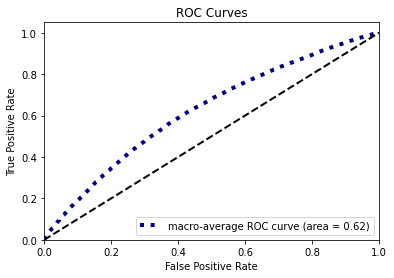

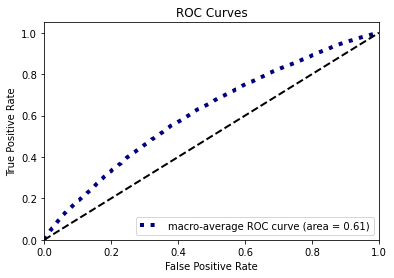

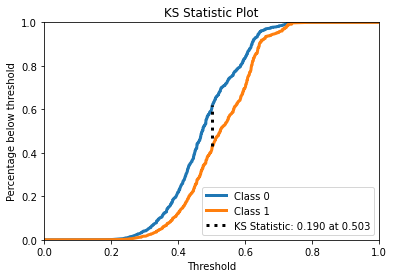

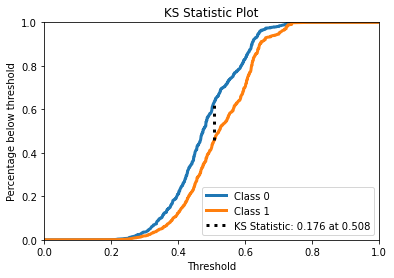

In [171]:
plot_roc_curve(y_probas=lr.predict_proba(train[varw]),y_true=train[vart[0]],curves='macro')
plot_roc_curve(y_probas=lr.predict_proba(val[varw]),y_true=val[vart[0]],curves='macro')

plot_ks_statistic(y_probas=lr.predict_proba(train[varw]),y_true=train[vart[0]])
plot_ks_statistic(y_probas=lr.predict_proba(val[varw]),y_true=val[vart[0]])

## Scoring

In [218]:
score_base = 550
momios_base = 1
pdo = 250
factor = pdo/np.log(2)
offset = score_base-factor*np.log(momios_base)
n = len(varw)
factor,offset,n

(360.67376022224084, 550.0, 3)

In [219]:
betas,alpha = list(lr.coef_[0]),lr.intercept_[0]
betas,alpha

([-1.042475375865602, -1.00333381702326, -0.9717543158142226],
 0.01064609663462699)

In [220]:
for beta,v in zip(betas,varw):
    train[f'P_{v}'] = np.round((-train[v]*beta+alpha/n)*factor+offset/n,0)
    val[f'P_{v}'] = np.round((-val[v]*beta+alpha/n)*factor+offset/n,0)
    test[f'P_{v}'] = np.round((-test[v]*beta+alpha/n)*factor+offset/n,0)

In [221]:
train['score'] = train.filter(like='P_').sum(axis=1)
val['score'] = val.filter(like='P_').sum(axis=1)
test['score'] = test.filter(like='P_').sum(axis=1)

In [222]:
aux = test['score'].describe().to_frame().T
aux['max'],aux['min'],aux['max']-aux['min']

(score    1146.0
 Name: max, dtype: float64,
 score    75.0
 Name: min, dtype: float64,
 score    1071.0
 dtype: float64)

<AxesSubplot:xlabel='score', ylabel='Density'>

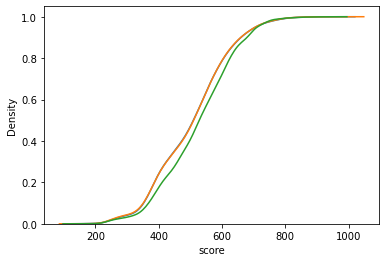

In [202]:
sns.kdeplot(data=train,x='score',cumulative=True)
sns.kdeplot(data=val,x='score',cumulative=True)
sns.kdeplot(data=test,x='score',cumulative=True)

In [228]:
train['r_score'] = pd.cut(train['score'],bins=range(74,1146+70,130),include_lowest=True).astype(str)
val['r_score'] = pd.cut(val['score'],bins=range(74,1146+70,130),include_lowest=True).astype(str)
test['r_score'] = pd.cut(test['score'],bins=range(74,1146+70,130),include_lowest=True).astype(str)

In [231]:
train

,linea,fecha,d_c_tiempo_espera,n_d_motivo,d_c_tiempo_tramite,target,w_d_c_tiempo_espera,w_n_d_motivo,w_d_c_tiempo_tramite,proba,P_w_d_c_tiempo_espera,P_w_n_d_motivo,P_w_d_c_tiempo_tramite,score,r_score
0,7751448632,2021-05-29,(30seg - 1min],PEQUEÑAS CATEGORÍAS,(0 - 10min],1,0.072040,0.088052,-0.101599,0.486486,212.0,216.0,149.0,577.0,"(464.0, 594.0]"
1,7774500954,2021-08-01,+15,T COTIZACION DE PUNTOS DE CIRCULO AZUL,(10min - 20min],0,-0.383854,-0.391381,-0.162102,0.723325,40.0,43.0,128.0,211.0,"(204.0, 334.0]"
2,5530454773,2021-12-05,(0 - 30seg],T DESEMPLEO / FALTA DE LIQUIDEZ,(10min - 20min],1,0.142734,-0.440752,-0.162102,0.613392,238.0,25.0,128.0,391.0,"(334.0, 464.0]"
3,3121388817,2021-06-11,(0 - 30seg],A POR ROBO Y/O EXTRAVIO,(10min - 20min],0,0.142734,0.509781,-0.162102,0.379397,238.0,369.0,128.0,735.0,"(724.0, 854.0]"
4,4775647699,2021-07-24,(4min - 8min],T COTIZACION DE PUNTOS DE CIRCULO AZUL,(10min - 20min],1,-0.024879,-0.391381,-0.162102,0.642628,175.0,43.0,128.0,346.0,"(334.0, 464.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36140,8713355752,2021-03-28,(2min - 4min],T INFORMES DE CONTRATACION Y PRECIOS DE EQUIPOS,(0 - 10min],0,-0.003496,-0.028050,-0.101599,0.535232,183.0,174.0,149.0,506.0,"(464.0, 594.0]"
36141,4772646016,2021-09-27,(30seg - 1min],A POR ROBO Y/O EXTRAVIO,(10min - 20min],1,0.072040,0.509781,-0.162102,0.396897,212.0,369.0,128.0,709.0,"(594.0, 724.0]"
36142,5522173334,2021-12-20,(0 - 30seg],T POR SALDOS DE VOZ,(20min - 30min],1,0.142734,-0.473920,-0.051263,0.595600,238.0,13.0,167.0,418.0,"(334.0, 464.0]"
36143,9982464662,2021-12-15,(0 - 30seg],T CONTRATACION DE LINEA,+1hr,1,0.142734,0.343673,0.251263,0.325824,238.0,309.0,273.0,820.0,"(724.0, 854.0]"


In [232]:
varp = [v for v in train.columns if v[:2]=='P_']

In [233]:
varp

['P_w_d_c_tiempo_espera', 'P_w_n_d_motivo', 'P_w_d_c_tiempo_tramite']

### Scorecard

In [240]:
varp = [v for v in train.columns if v[:2]=='P_']
sc = []
for v in varp:
    nombre = "_".join(v.split('_')[2:])
    nombre = "_".join(nombre.split('_')[2:])
    aux = train[[v,v[4:]]].drop_duplicates().reset_index(drop=True).assign(caracteristica=nombre)
    aux.columns = ['puntos','atributo','caracteristica']
    sc.append(aux)
aux = pd.concat(sc,ignore_index=True)
sc = aux.groupby(['caracteristica','atributo']).min()
sc

puntos
caracteristica atributo                                                  
motivo         A CAMBIO DE EQUIPO PREPAGO                           638.0
               A CONFIGURACION / FUNCIONES DEL EQUIPO               510.0
               A INFORMES DE PORTABILIDAD                           296.0
               A INFORMES DE PRECIOS DE EQUIPOS                     158.0
               A INGRESO Y ENTREGA DE EQUIPO (REVISION / REPAR...   303.0
               A MONITOREO DE LINEA                                 257.0
               A POR ACTUALIZACION VERSION                          243.0
               A POR DA?O / GARANTIA                                419.0
               A POR ROBO Y/O EXTRAVIO                              369.0
               A POR SALDO DE VOZ                                    92.0
               A PORTABILIDAD                                       255.0
               A VENTA DE AMIGO CHIP (VOZ)                          390.0
               A VENTA DE AMIGO KIT                                 286.0
               ACLARACION DE SALDO                                   99.0
               C ACLARACION DE SALDOS POR DATOS A GRANEL            141.0
               PEQUEÑAS CATEGORÍAS                                  216.0
               RETENCION GSM                                        437.0
               T ACLARACION DE SALDOS POR DATOS A GRANEL             35.0
               T ALTA / BAJA DE SERVICIOS ADICIONALES               433.0
               T CAMBIO DE FORMA DE PAGO                            368.0
               T CAMBIO DE IMEI CON REACTIVACION                    183.0
               T CAMBIO DE PLAN                                      71.0
               T CAMBIO PLAN                                         14.0
               T CARGO POR FIANZA                                   -11.0
               T CESION DE DERECHOS                                  32.0
               T CONFIGURACION / FUNCIONES DEL EQUIPO               309.0
               T CONTRATACION DE LINEA                              309.0
               T COTIZACION DE PUNTOS DE CIRCULO AZUL                43.0
               T DESEMPLEO / FALTA DE LIQUIDEZ                       25.0
               T INFORMES DE CONTRATACION Y PRECIOS DE EQUIPOS      174.0
               T INFORMES DE TARIFA DE VOZ Y DATOS                   34.0
               T INGRESO Y ENTREGA DE EQUIPO (REVISION / REPAR...   227.0
               T MIGRACION A PREPAGO                                -92.0
               T MIGRACION PREPAGO A POSTPAGO                       392.0
               T MONITOREO DE LINEA                                 205.0
               T POR ACTUALIZACION DE VERSION                        54.0
               T POR CIRCULO AZUL                                   102.0
               T POR ROBO Y/O EXTRAVIO                              207.0
               T POR SALDO DE DATOS                                  39.0
               T POR SALDOS DE VOZ                                   13.0
               T PROPIO (SWITCHEO)                                  242.0
               T RENOVACION (CIRCULO AZUL)                          292.0
               T RETENCION                                          395.0
               T VALE INBURSA                                       203.0
               T VENTA DE EQUIPO PRECIO PUBLICO                     129.0
tiempo_espera  (0 - 30seg]                                          238.0
               (1min - 2min]                                        207.0
               (2min - 4min]                                        183.0
               (30seg - 1min]                                       212.0
               (4min - 8min]                                        175.0
               (8min - 15min]                                       177.0
               +15                                                   40.0
tiempo_tramite (0 - 10min]                                          149

In [241]:
sc.to_clipboard()

## Reportes

In [242]:
aux = pd.concat([train.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='ent'),\
val.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='val'),\
test.merge(df[um],on=um,how='inner')[um+vart+['r_score']].assign(muestra='test')],ignore_index=True)

In [243]:
aux

,linea,fecha,target,r_score,muestra
0,7751448632,2021-05-29,1,"(464.0, 594.0]",ent
1,7774500954,2021-08-01,0,"(204.0, 334.0]",ent
2,5530454773,2021-12-05,1,"(334.0, 464.0]",ent
3,3121388817,2021-06-11,0,"(724.0, 854.0]",ent
4,4775647699,2021-07-24,1,"(334.0, 464.0]",ent
...,...,...,...,...,...
98356,9999940590,2021-12-16,0,"(594.0, 724.0]",test
98357,9999945098,2021-12-11,0,"(594.0, 724.0]",test
98358,9999950074,2021-12-16,0,"(464.0, 594.0]",test
98359,9999966195,2021-12-17,0,"(464.0, 594.0]",test


In [244]:
aux['fecha'] = pd.to_datetime(aux['fecha']).map(lambda x:x.strftime('%Y%m'))

In [248]:
aux.groupby(['fecha','r_score','muestra','target']).count().to_clipboard()

In [246]:
df['target'].value_counts(1)

0    0.912023
1    0.087977
Name: target, dtype: float64

In [247]:
aux['r_score'].value_counts()

(594.0, 724.0]     29132
(464.0, 594.0]     25393
(334.0, 464.0]     22774
(724.0, 854.0]     12638
(204.0, 334.0]      4439
(854.0, 984.0]      2607
(73.999, 204.0]     1001
(984.0, 1114.0]      338
Name: r_score, dtype: int64